Testing pycaret on the first 5 hop feature dfs. I could not do more then that since it would take to long.



In [ ]:
!pip install pyTDC
!pip install pycaret

     |████████████████████████████████| 85 kB 3.7 MB/s 
  Created wheel for pyTDC: filename=PyTDC-0.3.1-py3-none-any.whl size=116110 sha256=c0de496f92a55e48d2c57210b786e04ee51df8c860b2b4ca306f1a6861b05024
  Stored in directory: /root/.cache/pip/wheels/a9/54/07/50251965a66a68eb6c0e2b3022588cc992cc4c2a2e69d8c7ec
Successfully built pyTDC
     |████████████████████████████████| 266 kB 15.6 MB/s 
     |████████████████████████████████| 6.8 MB 69.3 MB/s 
     |████████████████████████████████| 261 kB 65.4 MB/s 
     |████████████████████████████████| 111 kB 69.7 MB/s 
     |████████████████████████████████| 14.6 MB 66.4 MB/s 
     |████████████████████████████████| 167 kB 68.7 MB/s 
     |████████████████████████████████| 2.0 MB 79.2 MB/s 
     |████████████████████████████████| 1.7 MB 79.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |███████████████████████

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import networkx as nx
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_curve, auc
from tdc import utils
from tdc.benchmark_group import admet_group
from sklearn.decomposition import PCA
import lightgbm as lgb
from pycaret.utils import enable_colab 
enable_colab()
import glob

from tdc.benchmark_group import admet_group
group = admet_group(path = 'data/')
benchmark = group.get('cyp2c9_veith')
targets =  benchmark['train_val']['Y'].astype(np.bool)


Mounted at /content/drive


Colab mode enabled.


100%|██████████| 1.47M/1.47M [00:00<00:00, 2.47MiB/s]
Extracting zip file...
Done!


In [ ]:
def get_larger_file_names():
  """
  Returns the file location for the 10_000 bucket color embeddings.
  """
  return glob.glob('/content/drive/MyDrive/SpringBoard/Therapeutic Data Commons Projects/data/more_buckets_data/*hop_larger_embedding.csv')

def load_larger_embedding_dfs():
  file_names = get_larger_file_names()
  feature_dfs = []
  for file in file_names[:5]:
    df = pd.read_csv(file, index_col=0)
    df = df.astype(np.int16)
    df['target'] = targets
    feature_dfs.append(df)
    print('read in a file') 
     
  return feature_dfs

feature_dfs = load_larger_embedding_dfs()

read in a file
read in a file
read in a file
read in a file
read in a file


# Run Pycaret

In [ ]:
%%time
# from pycaret.classification import *
# from sklearn.metrics import average_precision_score

# best_models = dict()

# # 30 DataFrames each with 10_000 columns and ~9673 rows.
# for hop_num, df in enumerate(feature_dfs):
#   grid = setup(data=df, target='target', silent=True, use_gpu = True)
#   add_metric('apc', 'APC', average_precision_score, target = 'pred_proba') 
#   best = compare_models(turbo=True, sort = 'APC')
#   best_models[hop_num] = best
#   print('read in a file')
#   print(best)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.87 µs


# Tune Models


In [ ]:
from pycaret.classification import *
from sklearn.metrics import average_precision_score # analog for AUPRC
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import make_scorer


In [ ]:
def compute_auprc(model, X_test, y_test):
    # https://stats.stackexchange.com/questions/157012/area-under-precision-recall-curve-auc-of-pr-curve-and-average-precision-ap
    precision, recall, thresholds = precision_recall_curve(y_test, model.predict(X_test))
    area = auc(recall, precision)
    return area

In [ ]:
zero_hop_df = feature_dfs[0]
one_hop_df = feature_dfs[1]
two_hop_df = feature_dfs[2]
three_hop_df = feature_dfs[3]
four_hop_df = feature_dfs[4]

In [ ]:
%%time
grid = setup(data=zero_hop_df, target='target', silent=True, use_gpu = True)
add_metric('apc', 'APC', average_precision_score, target = 'pred_proba')
zero_hop_model = create_model('lightgbm')
tuned_zero_hop_model = tune_model(zero_hop_model,optimize='APC',return_tuner=True, n_iter=50)


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
0,0.7729,0.8510,0.6316,0.6729,0.6516,0.4833,0.4839,0.7485
1,0.7858,0.8507,0.6432,0.6952,0.6682,0.5104,0.5113,0.7354
2,0.7799,0.8467,0.5947,0.7031,0.6444,0.4866,0.4902,0.7394
3,0.8198,0.8756,0.6564,0.7720,0.7095,0.5801,0.5842,0.7815
4,0.8154,0.8780,0.6520,0.7629,0.7031,0.5703,0.5740,0.7822
5,0.7976,0.8422,0.6256,0.7320,0.6746,0.5291,0.5325,0.7345
6,0.7829,0.8468,0.6491,0.6884,0.6682,0.5070,0.5075,0.7271
7,0.7858,0.8511,0.6272,0.7044,0.6636,0.5073,0.5091,0.7562
8,0.8154,0.8778,0.6404,0.7725,0.7002,0.5685,0.5737,0.7929
9,0.7917,0.8489,0.6535,0.7062,0.6788,0.5251,0.5259,0.7313


CPU times: user 1min 58s, sys: 4.95 s, total: 2min 3s
Wall time: 3min 13s


In [ ]:
from sklearn.model_selection import KFold, train_test_split
from copy import deepcopy
features = [c for c in zero_hop_df.columns if 'color' in c]
target = 'target'
auprc_scores = []

for i in range(20): 
  X_train, X_test, y_train, y_test = train_test_split(zero_hop_df[features], zero_hop_df[target], test_size=.2,random_state=i )
  tuned_lgbm_model = deepcopy(tuned_zero_hop_model[0])
  tuned_lgbm_model.fit(X_train,y_train)
  y_preds = tuned_lgbm_model.predict(X_test)
  auprc = compute_auprc(y_test, y_preds)
  auprc_scores.append(auprc)
  print(auprc)

avg_auprc = np.mean(auprc_scores)
print(f'The zero hop feature df trained on a tuned LGBM model has an average AUPRC of {avg_auprc}')


Finished loading model, total used 170 iterations
0.7394264863893283
Finished loading model, total used 170 iterations
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
0.7461121349922291
Finished loading model, total used 170 iterations
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
0.7329300807251122
Finished loading model, total used 170 iterations
[LightGBM] [Warning] feature_fraction is set=

## 1 hop df


In [ ]:
%%time
grid = setup(data=one_hop_df, target='target', silent=True, use_gpu = True)
add_metric('apc', 'APC', average_precision_score, target = 'pred_proba')
one_hop_model = create_model('rf')
tuned_one_hop_model = tune_model(one_hop_model, optimize='APC', return_tuner=True, n_iter=50)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
0,0.7758,0.8518,0.7222,0.6602,0.6898,0.5148,0.5161,0.7611
1,0.7947,0.8565,0.7639,0.6794,0.7192,0.5582,0.5606,0.7695
2,0.7932,0.8659,0.7768,0.6729,0.7211,0.5581,0.5618,0.7676
3,0.7563,0.8278,0.7210,0.6269,0.6707,0.4787,0.4817,0.7220
4,0.7784,0.8403,0.7597,0.6531,0.7024,0.5275,0.5313,0.7253
5,0.7740,0.8400,0.7554,0.6471,0.6970,0.5185,0.5225,0.7241
6,0.7637,0.8540,0.7350,0.6370,0.6825,0.4958,0.4991,0.7485
7,0.7607,0.8354,0.7735,0.6241,0.6908,0.4993,0.5069,0.7036
8,0.7578,0.8524,0.7265,0.6296,0.6746,0.4832,0.4864,0.7352
9,0.7548,0.8362,0.7393,0.6223,0.6758,0.4810,0.4856,0.7174


CPU times: user 4min 33s, sys: 9.03 s, total: 4min 42s
Wall time: 28min 27s


In [ ]:
tuned_one_hop_model[0]

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=11, max_features=1.0,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0002, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=7,
                       min_weight_fraction_leaf=0.0, n_estimators=220,
                       n_jobs=-1, oob_score=False, random_state=8939, verbose=0,
                       warm_start=False)

In [ ]:
features = [c for c in one_hop_df.columns if 'color' in c]
target = 'target'
auprc_scores = []

for i in range(20): 
  X_train, X_test, y_train, y_test = train_test_split(one_hop_df[features], one_hop_df[target], test_size=.2,random_state=i )
  tuned_rf_model = deepcopy(tuned_one_hop_model[0]) # this is the hyperparams of the tuned model
  tuned_rf_model.fit(X_train,y_train)
  y_preds = tuned_rf_model.predict(X_test)
  auprc = compute_auprc(y_test, y_preds)
  auprc_scores.append(auprc)
  print(auprc)

avg_auprc = np.mean(auprc_scores)
print(f'The one hop feature df trained on a tuned Random Forest Classifier has an average AUPRC of {avg_auprc}')

0.7290632167117688
0.7301008101704053
0.7237900765161327
0.7306888594852572
0.7387981091565289
0.7508991549689225
0.739066251730425
0.7149466464852223
0.7468288978548812
0.7350360584101223
0.7409540659834751
0.7032216136431855
0.734780849922095
0.7331964409358713
0.7053694618146649
0.7440699106896209
0.7340020592300703
0.7528699768884398
0.7383554813559075
0.7560383874143716
The one hop feature df trained on a tuned Random Forest Classifier has an average AUPRC of 0.7341038164683683


In [ ]:
from sklearn.model_selection import cross_validate

def create_tuned_model(hop_df, model_type:str, n_iter:int):
  grid = setup(data=hop_df, target='target', silent=True, use_gpu = True)
  add_metric('apc', 'APC', average_precision_score, target = 'pred_proba')
  model = create_model(model_type)
  tuned_model = tune_model(model, optimize='APC',return_tuner=True, n_iter=n_iter)
  return tuned_model[0]


def evaluate_cross_validation_models(tuned_model, hop_df):
  print(f'The Tuned Model is {tuned_model}\n\n')
  features = [c for c in hop_df.columns if 'color' in c]
  target = 'target'
  custom_auprc_scorer = make_scorer(compute_auprc, greater_is_better=True)
  cv_scores = cross_validate(estimator=tuned_model, X=hop_df[features], y=hop_df[target], cv=5, scoring=custom_auprc_scorer)
  avg_auprc = np.mean(cv_scores['test_score'])
  print(f'Average AUPRC on 5 fold CV on the tuned model is: {avg_auprc} \n\n')
  return avg_auprc


def tune_and_cv(hop_df, model_type, n_iter=500):
  """
    Given a hop_df and a model_type sting as seen in https://pycaret.org/create-model/
    Use pycaret random search to find the best amoung 50 hyper parameters and return the found model and the 5 fold cross validation scores
  """
  tuned_model = create_tuned_model(hop_df, model_type, n_iter)
  avg_auprc = evaluate_cross_validation_models(tuned_model, hop_df)
  return tuned_model, avg_auprc


In [ ]:
tuned_model, avg_auprc = tune_and_cv(zero_hop_df, 'lightgbm')
print(tuned_model)
print(avg_auprc)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
0,0.7788,0.8506,0.6316,0.6857,0.6575,0.4945,0.4955,0.7444
1,0.7814,0.8654,0.6256,0.6927,0.6574,0.4975,0.4989,0.7521
2,0.8168,0.8705,0.6916,0.7441,0.7169,0.5818,0.5826,0.7808
3,0.7932,0.8621,0.6696,0.7005,0.6847,0.5310,0.5313,0.7487
4,0.7873,0.8519,0.6079,0.7150,0.6571,0.5044,0.5079,0.7364
5,0.7696,0.8594,0.5991,0.6766,0.6355,0.4680,0.4698,0.7337
6,0.7962,0.8806,0.6228,0.7320,0.6730,0.5263,0.5299,0.7693
7,0.7725,0.8295,0.6009,0.6850,0.6402,0.4749,0.4771,0.7162
8,0.8006,0.8619,0.6842,0.7123,0.6980,0.5492,0.5495,0.7550
9,0.8006,0.8659,0.6228,0.7435,0.6778,0.5350,0.5394,0.7729


The Tuned Model is LGBMClassifier(bagging_fraction=1.0, bagging_freq=1, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.8,
               importance_type='split', learning_rate=0.05, max_depth=-1,
               min_child_samples=31, min_child_weight=0.001, min_split_gain=0,
               n_estimators=150, n_jobs=-1, num_leaves=70, objective=None,
               random_state=7556, reg_alpha=1e-07, reg_lambda=4, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current v

In [ ]:
tuned_model, avg_auprc = tune_and_cv(one_hop_df, 'lightgbm')
print(tuned_model)
print(avg_auprc)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
0,0.8289,0.8993,0.7105,0.7642,0.7364,0.6100,0.6109,0.8040
1,0.8198,0.8953,0.6623,0.7704,0.7123,0.5822,0.5857,0.8163
2,0.8065,0.8811,0.6360,0.7513,0.6888,0.5498,0.5539,0.7881
3,0.8198,0.8900,0.6798,0.7598,0.7176,0.5859,0.5878,0.8013
4,0.8109,0.8798,0.7105,0.7232,0.7168,0.5749,0.5750,0.7950
5,0.7873,0.8444,0.6491,0.6981,0.6727,0.5155,0.5162,0.7299
6,0.8449,0.8977,0.7149,0.8030,0.7564,0.6432,0.6455,0.8099
7,0.8035,0.8862,0.6360,0.7436,0.6856,0.5440,0.5475,0.7854
8,0.8168,0.8782,0.6784,0.7512,0.7130,0.5790,0.5806,0.8020
9,0.8183,0.8831,0.6916,0.7476,0.7185,0.5847,0.5857,0.7749


The Tuned Model is LGBMClassifier(bagging_fraction=0.9, bagging_freq=7, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.4,
               importance_type='split', learning_rate=0.15, max_depth=-1,
               min_child_samples=1, min_child_weight=0.001, min_split_gain=0.5,
               n_estimators=260, n_jobs=-1, num_leaves=150, objective=None,
               random_state=7381, reg_alpha=0.001, reg_lambda=0.15, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Curr

In [ ]:
tuned_model, avg_auprc = tune_and_cv(two_hop_df, 'lightgbm')
print(tuned_model)
print(avg_auprc)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
0,0.8348,0.8900,0.7061,0.7816,0.7419,0.6209,0.6226,0.7950
1,0.8109,0.8796,0.6754,0.7404,0.7064,0.5674,0.5687,0.7849
2,0.7976,0.8618,0.6476,0.7206,0.6821,0.5343,0.5360,0.7451
3,0.8095,0.8581,0.6916,0.7269,0.7088,0.5673,0.5677,0.7462
4,0.7917,0.8505,0.6432,0.7087,0.6744,0.5218,0.5231,0.7441
5,0.8124,0.8679,0.6828,0.7381,0.7094,0.5712,0.5721,0.7668
6,0.8139,0.8936,0.6432,0.7644,0.6986,0.5654,0.5698,0.8064
7,0.8095,0.8757,0.6784,0.7333,0.7048,0.5644,0.5654,0.7969
8,0.8080,0.8752,0.6784,0.7299,0.7032,0.5616,0.5624,0.7748
9,0.8301,0.8871,0.7004,0.7718,0.7344,0.6100,0.6115,0.8002


The Tuned Model is LGBMClassifier(bagging_fraction=0.7, bagging_freq=5, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.4,
               importance_type='split', learning_rate=0.2, max_depth=-1,
               min_child_samples=1, min_child_weight=0.001, min_split_gain=0.6,
               n_estimators=280, n_jobs=-1, num_leaves=150, objective=None,
               random_state=1169, reg_alpha=0.005, reg_lambda=5, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current 

In [83]:
tuned_model, avg_auprc = tune_and_cv(three_hop_df, 'lightgbm')
print(tuned_model)
print(avg_auprc)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
0,0.7920,0.8625,0.6106,0.7225,0.6619,0.5132,0.5170,0.7483
1,0.7696,0.8494,0.6000,0.6716,0.6338,0.4665,0.4681,0.7347
2,0.7903,0.8473,0.5600,0.7456,0.6396,0.4959,0.5060,0.7353
3,0.7829,0.8544,0.5778,0.7143,0.6388,0.4861,0.4916,0.7506
4,0.7888,0.8434,0.5956,0.7204,0.6521,0.5024,0.5071,0.7272
5,0.8050,0.8726,0.6133,0.7541,0.6765,0.5390,0.5449,0.7770
6,0.7976,0.8579,0.5973,0.7459,0.6634,0.5212,0.5278,0.7765
7,0.7843,0.8436,0.5664,0.7273,0.6368,0.4868,0.4945,0.7527
8,0.7873,0.8368,0.6018,0.7158,0.6538,0.5020,0.5059,0.7114
9,0.7829,0.8454,0.5885,0.7112,0.6441,0.4898,0.4944,0.7572


The Tuned Model is LGBMClassifier(bagging_fraction=0.8, bagging_freq=6, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.5,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=6, min_child_weight=0.001, min_split_gain=0.7,
               n_estimators=290, n_jobs=-1, num_leaves=256, objective=None,
               random_state=6028, reg_alpha=0.3, reg_lambda=3, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current va

In [77]:
tuned_model, avg_auprc = tune_and_cv(four_hop_df, 'lightgbm')
print(tuned_model)tuned_model, avg_auprc = tune_and_cv(four_hop_df, 'lightgbm')
print(tuned_model)
print(avg_auprc)
print(avg_auprc)
# each of these takes about an hour. Need to have less random search iterations for the other models since they are slower 

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
0,0.7493,0.7818,0.4891,0.6788,0.5685,0.3983,0.4089,0.6621
1,0.7770,0.8372,0.5570,0.7175,0.6272,0.4716,0.4793,0.7248
2,0.7489,0.8042,0.4298,0.7101,0.5355,0.3774,0.3997,0.6775
3,0.7548,0.8065,0.5088,0.6824,0.5829,0.4145,0.4234,0.6709
4,0.7548,0.7880,0.5219,0.6761,0.5891,0.4185,0.4256,0.6662
5,0.7533,0.7975,0.4825,0.6918,0.5685,0.4034,0.4162,0.6647
6,0.7415,0.8015,0.4868,0.6568,0.5592,0.3820,0.3906,0.6771
7,0.7696,0.8263,0.5153,0.7239,0.6020,0.4463,0.4590,0.7180
8,0.7518,0.8061,0.4760,0.6943,0.5648,0.3995,0.4135,0.6936
9,0.7371,0.8005,0.4541,0.6624,0.5389,0.3638,0.3765,0.6533


The Tuned Model is LGBMClassifier(bagging_fraction=0.6, bagging_freq=2, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.4,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=6, min_child_weight=0.001, min_split_gain=0.6,
               n_estimators=210, n_jobs=-1, num_leaves=200, objective=None,
               random_state=7614, reg_alpha=0.3, reg_lambda=1, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current va

# Test Hyper Params with the models found with compare_models()


In [ ]:
# best_models =  {
#   0: LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
#                 importance_type='split', learning_rate=0.1, max_depth=-1,
#                 min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
#                 n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
#                 random_state=4205, reg_alpha=0.0, reg_lambda=0.0, silent=True,
#                 subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
#  1: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
#                         criterion='gini', max_depth=None, max_features='auto',
#                         max_leaf_nodes=None, max_samples=None,
#                         min_impurity_decrease=0.0, min_impurity_split=None,
#                         min_samples_leaf=1, min_samples_split=2,
#                         min_weight_fraction_leaf=0.0, n_estimators=100,
#                         n_jobs=-1, oob_score=False, random_state=1025, verbose=0,
#                         warm_start=False),
#  2: LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
#                 importance_type='split', learning_rate=0.1, max_depth=-1,
#                 min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
#                 n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
#                 random_state=1169, reg_alpha=0.0, reg_lambda=0.0, silent=True,
#                 subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
#  3: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
#                     intercept_scaling=1, l1_ratio=None, max_iter=1000,
#                     multi_class='auto', n_jobs=None, penalty='l2',
#                     random_state=570, solver='lbfgs', tol=0.00LogisticRegression01, verbose=0,
#                     warm_start=False),
#  4: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
#                     intercept_scaling=1, l1_ratio=None, max_iter=1000,
#                     multi_class='auto', n_jobs=None, penalty='l2',
#                     random_state=6402, solver='lbfgs', tol=0.0001, verbose=0,
#                     warm_start=False)}

# This was the models that were saved as the best from the previous run.


# Smaller number of hyperparams tested


In [78]:
%%time
tuned_model, avg_auprc = tune_and_cv(zero_hop_df, 'lightgbm', 50)
print(tuned_model)
print(avg_auprc)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
0,0.7670,0.8583,0.5565,0.6957,0.6184,0.4536,0.4594,0.7466
1,0.7962,0.8650,0.6652,0.7150,0.6892,0.5378,0.5386,0.7508
2,0.7784,0.8427,0.6087,0.7000,0.6512,0.4900,0.4925,0.7212
3,0.7962,0.8724,0.6348,0.7300,0.6791,0.5308,0.5336,0.7686
4,0.7814,0.8487,0.5895,0.7143,0.6459,0.4899,0.4946,0.7320
5,0.7518,0.8127,0.6070,0.6406,0.6233,0.4385,0.4388,0.6823
6,0.8080,0.8605,0.6507,0.7487,0.6963,0.5569,0.5598,0.7622
7,0.7858,0.8612,0.6594,0.6927,0.6756,0.5159,0.5162,0.7657
8,0.8021,0.8483,0.6245,0.7487,0.6810,0.5392,0.5438,0.7478
9,0.7917,0.8588,0.6201,0.7245,0.6682,0.5178,0.5211,0.7457


The Tuned Model is LGBMClassifier(bagging_fraction=0.4, bagging_freq=5, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.7,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=36, min_child_weight=0.001, min_split_gain=0.1,
               n_estimators=70, n_jobs=-1, num_leaves=80, objective=None,
               random_state=6135, reg_alpha=0.05, reg_lambda=0.005, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Curren

In [79]:
%%time
tuned_model, avg_auprc = tune_and_cv(one_hop_df, 'rf', 50) 
print(tuned_model)
print(avg_auprc)
# I suspect this would be better if I gave it 500 random hyper params to check

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
0,0.7714,0.8457,0.7783,0.6325,0.6979,0.5171,0.5243,0.7361
1,0.7696,0.8165,0.7380,0.6377,0.6842,0.5043,0.5077,0.6840
2,0.7386,0.8187,0.7424,0.5903,0.6576,0.4506,0.4583,0.6698
3,0.7459,0.8421,0.7904,0.5934,0.6779,0.4751,0.4884,0.7526
4,0.7415,0.8491,0.8079,0.5854,0.6789,0.4717,0.4888,0.7108
5,0.7947,0.8695,0.8079,0.6607,0.7269,0.5650,0.5724,0.7549
6,0.7356,0.8031,0.7380,0.5868,0.6538,0.4444,0.4520,0.6681
7,0.7829,0.8517,0.8166,0.6404,0.7179,0.5455,0.5562,0.7358
8,0.8006,0.8665,0.7478,0.6908,0.7182,0.5643,0.5653,0.7577
9,0.7622,0.8324,0.7739,0.6202,0.6886,0.5000,0.5080,0.7498


The Tuned Model is RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=9, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0001, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=190,
                       n_jobs=-1, oob_score=False, random_state=2833, verbose=0,
                       warm_start=False)


Average AUPRC on 5 fold CV on the tuned model is: 0.7327487147284087 


RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=9, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0001, min_impurity_split=None,
                       min_samples_leaf=5, min_sample

In [80]:
%%time
tuned_model, avg_auprc = tune_and_cv(two_hop_df, 'lightgbm', 50)
print(tuned_model)
print(avg_auprc)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
0,0.8142,0.8703,0.6711,0.7500,0.7083,0.5726,0.5745,0.7816
1,0.7991,0.8569,0.7004,0.7004,0.7004,0.5493,0.5493,0.7276
2,0.8242,0.8793,0.6256,0.8068,0.7047,0.5824,0.5920,0.7903
3,0.7725,0.8444,0.5991,0.6834,0.6385,0.4736,0.4758,0.7365
4,0.7903,0.8561,0.6300,0.7114,0.6682,0.5157,0.5177,0.7510
5,0.7976,0.8721,0.6564,0.7163,0.6851,0.5364,0.5375,0.7397
6,0.8139,0.8605,0.6828,0.7416,0.7110,0.5741,0.5752,0.7731
7,0.7814,0.8645,0.6123,0.6985,0.6526,0.4941,0.4964,0.7430
8,0.7784,0.8392,0.6579,0.6757,0.6667,0.5008,0.5009,0.7015
9,0.8065,0.8723,0.6754,0.7299,0.7016,0.5587,0.5597,0.7725


The Tuned Model is LGBMClassifier(bagging_fraction=0.5, bagging_freq=6, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=11, min_child_weight=0.001, min_split_gain=0,
               n_estimators=150, n_jobs=-1, num_leaves=150, objective=None,
               random_state=8457, reg_alpha=0.01, reg_lambda=0.3, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current 

In [81]:
%%time
tuned_model, avg_auprc = tune_and_cv(three_hop_df, 'lr', 50)
print(tuned_model)
print(avg_auprc)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
0,0.7876,0.8410,0.6987,0.6809,0.6897,0.5283,0.5284,0.7352
1,0.7917,0.8500,0.7061,0.6851,0.6955,0.5373,0.5374,0.7385
2,0.7843,0.8541,0.6842,0.6783,0.6812,0.5183,0.5183,0.7331
3,0.7725,0.8372,0.7193,0.6457,0.6805,0.5047,0.5065,0.7415
4,0.8035,0.8660,0.7193,0.7039,0.7115,0.5626,0.5627,0.7592
5,0.7651,0.8260,0.6579,0.6494,0.6536,0.4760,0.4760,0.7412
6,0.7962,0.8667,0.7105,0.6923,0.7013,0.5466,0.5467,0.7706
7,0.7666,0.8309,0.6667,0.6496,0.6580,0.4809,0.4810,0.7268
8,0.8109,0.8733,0.7412,0.7101,0.7253,0.5813,0.5816,0.7806
9,0.8080,0.8757,0.6987,0.7240,0.7111,0.5674,0.5676,0.7860


The Tuned Model is LogisticRegression(C=0.269, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=4816, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


Average AUPRC on 5 fold CV on the tuned model is: 0.7306399731828777 


LogisticRegression(C=0.269, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=4816, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
0.7306399731828777
CPU times: user 8min 44s, sys: 3min 13s, total: 11min 58s
Wall time: 30min 7s


In [82]:
%%time
tuned_model, avg_auprc = tune_and_cv(four_hop_df, 'lr', 50)
print(tuned_model)
print(avg_auprc)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
0,0.7566,0.7855,0.6407,0.6435,0.6421,0.4577,0.4577,0.6564
1,0.8080,0.8419,0.7087,0.7212,0.7149,0.5702,0.5702,0.7423
2,0.7696,0.8515,0.6391,0.6682,0.6533,0.4809,0.4812,0.7493
3,0.7430,0.7779,0.6174,0.6228,0.6201,0.4259,0.4259,0.6817
4,0.7223,0.7664,0.5696,0.5955,0.5822,0.3744,0.3746,0.6349
5,0.7371,0.7939,0.6174,0.6121,0.6147,0.4152,0.4152,0.6725
6,0.7770,0.8291,0.6783,0.6695,0.6739,0.5044,0.5044,0.7249
7,0.7563,0.8225,0.6304,0.6444,0.6374,0.4539,0.4539,0.6814
8,0.7474,0.7987,0.6147,0.6339,0.6242,0.4340,0.4341,0.7081
9,0.7533,0.7956,0.6104,0.6468,0.6281,0.4438,0.4442,0.6784


The Tuned Model is LogisticRegression(C=0.313, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=6800, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


Average AUPRC on 5 fold CV on the tuned model is: 0.6738654402974648 


LogisticRegression(C=0.313, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=6800, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
0.6738654402974648
CPU times: user 7min 57s, sys: 6min 26s, total: 14min 24s
Wall time: 25min 18s


# I think I should ensemble the predictions with some kind of Bayesian updating
 
This is because if the predictions of 3 models are [.8,.8,.8]. That is strong evidence that the true value is 1. I think I would get better results that way instead if I just averaged the probabilities.

I think I should just use the zero hop, one hop and two hop feature dfs. There is significant drop off in predictive power when you get to larger hop numbers.

The prior belief could be .33 since that is the portion of positive examples in the training data. That could cause problems down the line if someone uses this model on a bunch of data where the true prior is different. 
 
A more modest prior is .5 







# Questions

1. Should I do baysina updating here, what other ideas do you have?
2. How much Random searching should I do for the hyper params?

Something like this picture

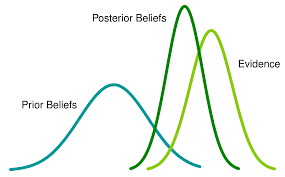